In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

ModuleNotFoundError: No module named 'matplotlib'

# IMPORTANT!
I need to keep track of which things shuffle the order of inputs when outputting its thing! It's made for (already several) very tough debugs!

# Arcus and Zhang Models of FRBs

## Star Formation Rates

In [2]:
#Star formation rate models, as defined by
#Zhang et al. 2020 and
#Arcus et al. 2020, respectively

def SFR_Zhang(z):
    '''
    ----------I/O-----------
    INPUT: z — redshift (single value or numpy array)
    OUTPUT: SFR — (relative) star formation rate
    ------------------------
    
    Notes:
    SFR as defined by Zhang et al. 2020. Looks like three separate regimes.
    '''
    a = 3.4
    b = -0.3
    c = -3.5
    B = 5000.0
    C = 9.0
    eta = -10.0
    return ((1+z)**(a*eta) + ((1+z)/B)**(b*eta) + ((1+z)/C)**(c*eta))**(1/eta)

def SFR_Arcus(z):
    '''
    ----------I/O-----------
    INPUT: z — redshift (single value or numpy array)
    OUTPUT: SFR — (relative) star formation rate
    ------------------------
    
    Notes:
    SFR as defined by Arcus et al. 2020. SFR looks like a smooth peak at around z=2.
    '''
    
    Z=1+z
    return (0.015*(Z**2.7))/(1+(Z/2.9)**5.6)

### Compare SFRs

In [3]:
#generate 200 redshifts between 0-10
zs = np.linspace(0,10,200)

#find SFR at each of these redshifts
ys_Zhang = SFR_Zhang(zs)
ys_Arcus = SFR_Arcus(zs)

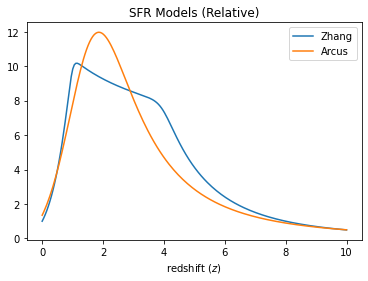

In [4]:
#plot and compare SFRs
plt.plot(zs, ys_Zhang, label='Zhang')
plt.plot(zs, ys_Arcus*90, label='Arcus')
plt.title("SFR Models (Relative)")
plt.legend()
plt.xlabel('redshift ($z$)')
plt.show()

## cosmology stuff

### cosmological model

In [5]:
#define cosmological model
cosm_model = [0.286, 0.714, 0.049, 70]
#Omega_M (matter), Omega_Lambda (dark energy), Omega_b (baryons), H_0 (Hubble constant, in km/s/Mpc)

#define constants
c = 299792458.0
H_0 = cosm_model[3]*3.24077929e-20 #convert km/s/Mpc to s^-1
Jyms = 1.0e-29 #1 Jy ms = 1.0e-29 J/(m^2 * Hz)
Gyr = 3.1556926e16 #number of seconds in 10^9 years

### cosmology functions $E(z)$, normalize(), luminosity/comoving distance
- note: luminosity distance matches with one cosmology calculator

In [6]:
def E(z):
    '''
    ----------I/O-----------
    INPUT: z — redshift (single value or np array)
    OUTPUT: E(z), defined so that H = H_0 * E(z) (provides Hubble parameter at arbitrary z)
    ------------------------
    
    Notes:
    Though not input, depends on cosm_model.
    '''
    
    O_M = cosm_model[0]
    O_L = cosm_model[1]
    return ((1+z)**3 * O_M + O_L)**0.5

def D_C(z):
    '''
    WARNING: input order is NOT same as output order
    
    ----------I/O-----------
    INPUT: z — redshift (single value or np array)
    OUTPUT: comoving distance, in units of hubble distances (c/H_0)
    ------------------------
    
    Notes:
    Currently using low precision, dz=0.01
    '''
    #TEST TEST TEST
    dz = 0.001 
    
    if not isinstance(z, np.ndarray):
        #single value
        zs = np.arange(0., z, dz)
        integral = 0
        for z_i in zs:
            integrand = (1/E(z_i) + 1/E(z_i+dz))/2.0
            integral += integrand*dz
        return integral
    
    sorted_zs = sorted(z)
    D_Cs = np.zeros(len(sorted_zs))
    ind = 0
    zs = np.arange(0., max(z)+dz, dz)
    integral = 0
    for z_i in zs:
        integrand = (1/E(z_i) + 1/E(z_i+dz))/2.0
        while(ind < len(sorted_zs) and sorted_zs[ind] < (z_i+dz)):
            D_Cs[ind] = integral + integrand * (sorted_zs[ind] - z_i)
            ind += 1
        integral += integrand*dz
    return D_Cs

def D_L(z, temp=False):
    '''
    WARNING: input order is NOT same as output order
    
    ----------I/O-----------
    INPUT: 
    z — redshift (single value or np array)
    temp - boolean indicating to use approximate analytic expression (temporary measure)
    
    OUTPUT: luminosity distance, in units of hubble distances (c/H_0)
    ------------------------
    
    Notes:
    Currently using low precision, dz=0.01
    temp expression only a good approximation for z<3, but good for testing.
    '''
    #temporary measure
    if temp:
        return 1.56391885121*(z**1.2290110356)
    return (1+z)*D_C(z)

def normalize(x, max_val=1):
    '''
    ----------I/O-----------
    INPUT: 
    x - any list/array
    max_val - the value of the maximum of the normalized array, default = 1.
    OUTPUT: 
    x normalized so that its maximum is max_val
    ------------------------
    
    Notes:
    N/A
    '''
    return x*max_val/max(x)

In [7]:
def t_L(z):
    '''
    WARNING: input order is NOT same as output order
    
    ----------I/O-----------
    INPUT: 
    z - redshift (single value or np array)
    OUTPUT: 
    t_L - lookback time(s) (in units of hubble times)
    ------------------------
    
    Notes:
    dz = 0.01
    returns a sorted array
    '''
    dz = 0.01
    
    if not isinstance(z, np.ndarray):
        integral = 0
        zs = np.arange(0., z, dz)
        for z_i in zs:
            integrand = (((1+z_i)*E(z_i))**(-1) + ((1+z_i+dz)*E(z_i+dz))**(-1))/2.0
            integral += integrand * dz
        return integral
    
    sorted_zs = sorted(z)
    t_Ls = np.zeros(len(sorted_zs))
    ind = 0
    zs = np.arange(0., max(z)+dz, dz)
    integral = 0
    for z_i in zs:
        integrand = (1/((1+z_i)*E(z_i)) + 1/((1+z_i+dz)*E(z_i+dz)))/2.0
        while(ind < len(sorted_zs) and sorted_zs[ind] < (z_i+dz)):
            t_Ls[ind] = integral + integrand * (sorted_zs[ind] - z_i)
            ind += 1
        integral += integrand*dz
    return t_Ls

In [8]:
zs = np.linspace(0,10,200)
tLs = t_L(zs)

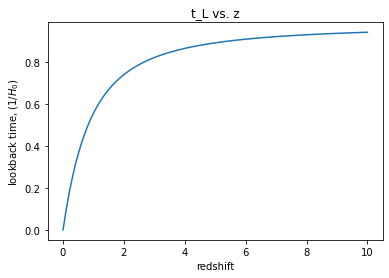

In [9]:
plt.title('t_L vs. z')
plt.plot(zs, tLs)
plt.xlabel('redshift')
plt.ylabel('lookback time, ($1/H_0$)')
plt.show()

## $\frac{dDM}{dz}$ models

In [10]:
#note: Arcus and Zhang also differ by a multiplicative constant

def dDMdz_Arcus(z): 
    '''
    ----------I/O-----------
    INPUT: z — redshift (single value or np array)
    OUTPUT: dDM/dz — increase in DM per increase z, in pc cm^-3
    ------------------------
    
    Notes:
    Three separate sections, corresponding to presence/lack of H or He.
    '''
    
    C = 3*(c*H_0)*(cosm_model[2])/(8*np.pi*6.67408e-11*1.6726219e-27) # SI units
    convert = 3.08567758e22 #1 pc cm^-3 in SI units
    fac = 0.75*np.piecewise(z, [z<8, z>=8], [1, 0]) + 0.125*np.piecewise(z, [z<2.5, z>=2.5], [1, 0])
    return (C/convert)*(1+z)*fac/E(z)

def dDMdz_Zhang(z):
    '''
    ----------I/O-----------
    INPUT: z — redshift (single value or np array)
    OUTPUT: dDM/dz — increase in DM per increase z, in pc cm^-3
    ------------------------
    
    Notes:
    One smooth peak with maximum at z<1.
    '''
    
    C = 3*(299792458)*(cosm_model[3]*3.24077929e-20)*(cosm_model[2])/(8*np.pi*6.67408e-11*1.6726219e-27)
    C *= (7./8.)*0.84
    convert = 3.08567758e22
    return (1+z)*(C/convert)/E(z)

### plot and compare $\frac{dDM}{dz}$ models

In [11]:
#generate data points

zs = np.linspace(0,10,200)
dDM_A = dDMdz_Arcus(zs)
dDM_Z = dDMdz_Zhang(zs)

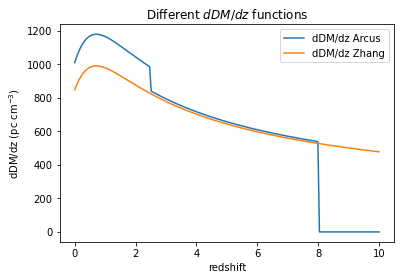

In [12]:
#plot
plt.plot(zs, dDM_A, label='dDM/dz Arcus')
plt.plot(zs, dDM_Z, label='dDM/dz Zhang')
plt.legend()
plt.ylabel('dDM/dz (pc cm$^{-3}$)')
plt.xlabel('redshift')
plt.title('Different $dDM/dz$ functions')
plt.show()

## DM(z), attempt at numerical integration

In [13]:
def DM_single_z(z, dDMdz=dDMdz_Arcus):
    '''
    ----------I/O-----------
    INPUT: 
    z     — redshift (single value)
    dDMdz — dDM/dz model used, default Arcus
    
    OUTPUT: 
    DM(z), single value of DM at redshift=z
    ------------------------
    
    Notes:
    z must be >= 0
    dz = 0.01 by default, no parameter to change
    '''
    
    if(z < 0):
        print('z out of range')
        return 0
    
    dz = 0.01
    DM = 0.0
    for z_ in np.arange(0, z, dz):
        DM += (dDMdz(z_) + dDMdz(z_+dz))*dz/2.0
    return DM
    

def DM(z, dDMdz=dDMdz_Arcus):
    '''
    WARNING: input order is NOT same as output order
    ----------I/O-----------
    INPUT: 
    z     — single value or array/list of redshift
    dDMdz — dDM/dz model used, default Arcus
    
    OUTPUT: 
    DM(z) — DM(z), in pc cm^-3, single value or list depending on z input
    ------------------------
    
    Notes:
    all values of z must be >= 0
    dz = 0.01 by default, no parameter to change
    '''
    
    if not isinstance(z, np.ndarray):
        return DM_single_z(z, dDMdz)
    
    if(min(z) < 0):
        print('z out of range')
        return z*0
    
    z_s = sorted(z)
    ind = 0
    DMs = np.array([])
    
    dz = 0.01
    DM = 0.0
    for z_ in np.arange(0, max(z)+2*dz, dz):
        DM += (dDMdz(z_) + dDMdz(z_+dz))*dz/2.0
        while(ind < len(z_s) and abs(z_s[ind]-z_) < dz):
            DMs = np.append(DMs, DM)
            ind += 1
    return DMs

### plot and compare

In [14]:
#generate data values: might take a while
zs = np.linspace(0,10,200)
DM_Arcus = DM(zs, dDMdz_Arcus)
DM_Zhang = DM(zs, dDMdz_Zhang)

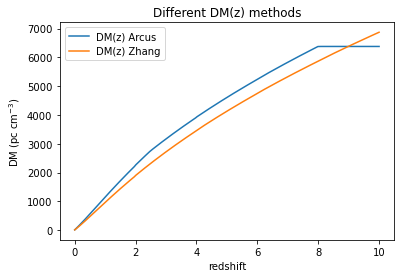

In [15]:
#plot
plt.plot(zs, DM_Arcus, label='DM(z) Arcus')
plt.plot(zs, DM_Zhang, label='DM(z) Zhang')
plt.legend()
plt.ylabel('DM (pc cm$^{-3}$)')
plt.xlabel('redshift')
plt.title('Different DM(z) methods')
plt.show()

### inverse function z(DM) function + test

In [16]:
from bisect import bisect_left as bleft
#behavior:
# if exactly at an element, returns that index
# if between two elements, returns index of right hand element
# if beyond range, returns right hand index (0 or len(arr))

from bisect import bisect_right as bright
#behavior:
#if exactly at an element, returns index+1
#if between two elements, returns right hand index
# if beyond range, returns right hand index (0 or len(arr))


def z_DM(DM, DMs, zs): #assumes DMs and zs already sorted
    '''
    ----------I/O-----------
    INPUT: 
    DM - a single value
    DMs - a pre-calculated & sorted list of DMs
    zs - a pre-calculated & sorted list of zs, that align one-to-one with DMs
    
    OUTPUT: 
    zs - linearly interpolated list of zs that correspond with the input DM
    ------------------------
    '''
    if(DM > max(DMs) or DM < min(DMs)):
        print('DM out of range: ' + str(DM) + ' pc cm^-3')
        return 0
    
    i = bleft(DMs, DM)
    
    if (i != bright(DMs, DM)): #means that DM is exactly within DMs
        return zs[i]
    
    #if not exactly equal to one of data points, linearly interpolate
    return zs[i-1] + (zs[i]-zs[i-1])*(DM-DMs[i-1])/(DMs[i]-DMs[i-1])

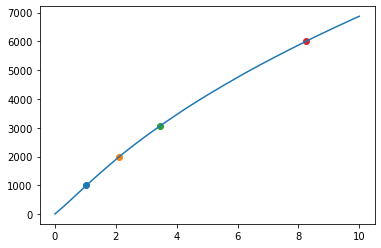

In [17]:
plt.plot(zs, DM_Zhang)
plt.scatter(z_DM(1000, DM_Zhang, zs), 1000)
plt.scatter(z_DM(2000, DM_Zhang, zs), 2000)
plt.scatter(z_DM(3059.1, DM_Zhang, zs), 3059.1)
plt.scatter(z_DM(6000, DM_Zhang, zs), 6000)

### inverse z(t_L):

In [18]:
def z_tL(t_L, tLs, zs):
    '''
    ----------I/O-----------
    INPUT: 
    t_L - single value
    tLs - pre-calculated & sorted list of lookback times
    zs  - pre-calculated & sorted list of zs, that correspond one-to-one with tLs
    
    OUTPUT: 
    list of zs that correspond to tLs, linearly interpolated
    ------------------------
    '''
    
    if(t_L > max(tLs) or t_L < min(tLs)):
        print('t_L out of range: ' + str(t_L) + ' hubble time(s)')
        return 0
    
    i = bleft(tLs, t_L)
    
    if (i != bright(tLs, t_L)): #means that t_L is exactly within tLs
        return zs[i]
    
    #if not exactly equal to one of data points, linearly interpolate
    return zs[i-1] + (zs[i]-zs[i-1])*(t_L-tLs[i-1])/(tLs[i]-tLs[i-1])

In [19]:
zs = np.linspace(0,10,200)
tLs = t_L(zs)

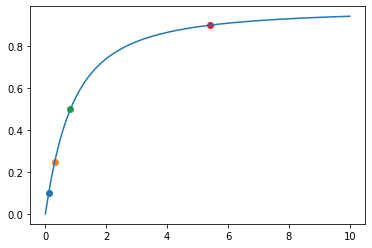

In [20]:
plt.plot(zs, tLs)
plt.scatter(z_tL(0.1, tLs, zs), 0.1)
plt.scatter(z_tL(0.25, tLs, zs), 0.25)
plt.scatter(z_tL(0.5, tLs, zs), 0.5)
plt.scatter(z_tL(0.9, tLs, zs), 0.9)

## dR/dz (differential event rate) Arcus model

In [21]:
def F_v(E, z, alpha):
    '''
    WARNING: input order is NOT same as output order
    
    ----------I/O-----------
    INPUT: 
    E - specific energy, in J/Hz
    z - redshift (single value or list)
    alpha - spectral index (F_v is proportional to v^-a)
    
    OUTPUT: 
    F_v (single val/list) corresponding with E, at z
    ------------------------
    '''
    return E*(1+z)**(2-alpha)/(4*np.pi*(D_L(z)*c/H_0)**2*Jyms)

def dRdz(z, n, F_0, SFR=SFR_Arcus, params=None):
    '''
    WARNING: input order is NOT same as output order
    
    ----------I/O-----------
    INPUT:
    z      — redshift (single value, numpy array)
    n      — power law w/ SFR
    F_0    — fluence limit of telescope (in Jy ms)
    SFR    – which SFR model to use, default Arcus
    params — [alpha, gamma, E_max, E_min], parameters of FRB energy distribution, (F_max/min in J/Hz), default None
        
    OUTPUT: 
    dR/dz(z, F>F_0) — differential FRB rate at z
    ------------------------
    
    Notes:
    Arcus model of dR/dz. 
    '''
    
    model = (1+z)*(SFR(z)**n)*(D_L(z)**2)/(E(z) * (1+z)**4)
    
    if params is None:
        return model
    
    alpha = params[0]
    gamma = params[1]
    #params[2] and [3] are E_max and E_min -> convert E (J/Hz) to F (Jy ms)
    F_max = F_v(params[2], z, alpha)
    F_min = F_v(params[3], z, alpha)
    exp = 1.0-gamma
    
    frac = (F_max**exp - F_0**exp)/(F_max**exp - F_min**exp)
    frac = np.piecewise(frac, [frac <= 0, (frac > 0) & (frac < 1), frac >= 1], [lambda x:0, lambda x:x, lambda x:1])
    
    return frac*model

### plot different dependences of rate on SFR

In [22]:
# get dR/dz for Parkes, for n=0,1,2 and no other params

zs = np.linspace(0,10,200)
dRdz_0 = dRdz(zs, n=0, F_0=3)
dRdz_1 = dRdz(zs, n=1, F_0=3) #F_0 = 3 Jy ms is parkes
dRdz_2 = dRdz(zs, n=2, F_0=3)

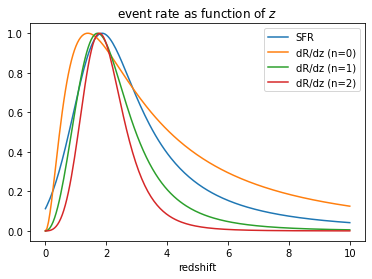

In [23]:
#plot
plt.plot(zs, normalize(ys_Arcus), label='SFR')
plt.plot(zs, normalize(dRdz_0), label='dR/dz (n=0)')
plt.plot(zs, normalize(dRdz_1), label='dR/dz (n=1)')
plt.plot(zs, normalize(dRdz_2), label='dR/dz (n=2)')
plt.legend()
plt.xlabel('redshift')
plt.title('event rate as function of $z$')
plt.show()

### plot rate vs. alpha/gamma

In [24]:
# get dR/dz for Parkes, for n=1, gamma=1.2, alpha = 1,2,3,4

zs = np.linspace(0,10,2000)
dRdz_a1 = dRdz(zs, n=0, F_0=3, params=[2.0, 1.3, 1.28e26, 1.28e22])
dRdz_a2 = dRdz(zs, n=1, F_0=3, params=[2.1, 1.7, 1.28e26, 1.28e22])
dRdz_a3 = dRdz(zs, n=2, F_0=3, params=[2.2, 2.0, 1.28e26, 1.28e22])
#dRdz_a4 = dRdz(zs, n=1, F_0=3, params=[1.0, 3.5, 1.28e29, 1.28e22])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide


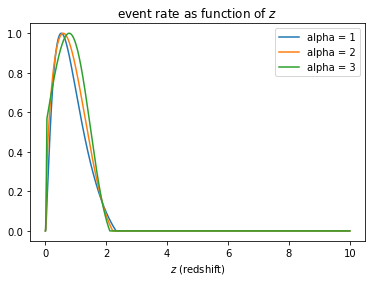

In [25]:
#plot
plt.plot(zs, normalize(dRdz_a1), label='alpha = 1')
plt.plot(zs, normalize(dRdz_a2), label='alpha = 2')
plt.plot(zs, normalize(dRdz_a3), label='alpha = 3')
#plt.plot(zs, normalize(dRdz_a4), label='alpha = 4')
plt.legend()
plt.xlabel('$z$ (redshift)')
plt.title('event rate as function of $z$')
plt.show()

## dR_F/dDM

### dR/dDM function

In [26]:
zs = np.linspace(0,10,200)
DM_Arcus = DM(zs, dDMdz_Arcus)
DM_model = [DM_Arcus, zs, dDMdz_Arcus]

def eff_estimate(DM):
    '''
    ----------I/O-----------
    INPUT: DM - (single val/np array) of DMs
    OUTPUT: estimate of efficiency of Parkes, as calculated in Arcus et al. 2020
    ------------------------
    '''
    return 0.902546109797 - 0.184416774387*((DM + 402.950615298)**0.153263945981)

def dRdDM(DM, n, F_0, SFR=SFR_Arcus, params=None, eff=False):
    '''
    WARNING: input order is NOT same as output order
    
    ----------I/O-----------
    INPUT: 
    DM     — list of DMs
    n      — power law w/ SFR
    F_0    — fluence limit of telescope (in Jy ms)
    SFR    – which SFR model to use, default Arcus
    params — [alpha, gamma, E_max, E_min], parameters of FRB energy distribution, (F_max/min in J/Hz), default None
    eff    – parameter to include efficiency [estimate]. default value is False
    
    OUTPUT: 
    dR/dDM(DM, F>F_0) — differential FRB rate at DM
    ------------------------
    
    Notes:
    N/A
    '''
    z_vals = np.zeros(len(DM))
    i = 0
    for DM_i in DM:
        z_vals[i] = z_DM(DM_i, DM_model[0], DM_model[1])
        i+=1
    dRdz_val = dRdz(z_vals, n, F_0, SFR=SFR, params=params)
    dDMdz_val = DM_model[2](z_vals)
    if eff:
        return dRdz_val*eff_estimate(DM)/dDMdz_val
    return dRdz_val/dDMdz_val

### plot some examples

In [27]:
# get dR/dz for Parkes, for n=0,1,2

DMs = np.linspace(0, 6000, 200)
gammas = [1.01, 1.1, 1.5, 2.0, 2.5, 3.0]
dRdDMs = []
for gamma in gammas:
    dRdDMs.append(dRdDM(DMs, n=2, F_0=3, params=[1.5, gamma, 7.4e25, 1.28e22], eff=False))

DM out of range: 0.0 pc cm^-3
DM out of range: 0.0 pc cm^-3
DM out of range: 0.0 pc cm^-3


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide


DM out of range: 0.0 pc cm^-3
DM out of range: 0.0 pc cm^-3
DM out of range: 0.0 pc cm^-3


In [28]:
def approx_integral(dRdDM, dDM):
    return sum(dRdDM*dDM)

dDM = DMs[1]-DMs[0]
As = []
for i in range(len(gammas)):
    As.append(approx_integral(dRdDMs[i], dDM))

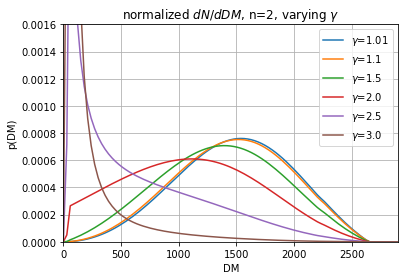

In [29]:
#plot
for i in range(len(gammas)):
    plt.plot(DMs, dRdDMs[i]/As[i], label=f'$\\gamma$={gammas[i]}')
plt.legend()
plt.ylabel('p(DM)')
plt.xlabel('DM')
plt.xlim([0,2900])
plt.ylim([0,0.0016])
plt.title('normalized $dN/dDM$, n=2, varying $\\gamma$')
plt.grid()
#plt.hist(DM_parkes, bins=6, density=True, alpha=0.3)
#plt.savefig('varyinggamma.png', dpi=600)
plt.show()


## <span style="color:red">notes: the plot is definitely wrong</span>
- for starters, the plot should cutoff at much lower DM, ~2000
- additionally, the spike due to the discontinuous DM Model should not be so prominent
- also, F_0 should have a big impact, unlike the minimal impact you see above

# Zhang et al. 2020 model

Monte Carlo using the "rejection method" in this website:
http://web.mit.edu/urban_or_book/www/book/chapter7/7.1.3.html

### below: some of my program's specifications for the simulation

In [30]:
max_SFRZ = 10.17407485592877
zs = np.linspace(0,8.1,500)
tL_model = [zs, t_L(zs)]

## simulating dN/dtdV

In [31]:
def samp_z(samp_size, delay=None, seed=0):
    '''
    ----------I/O-----------
    INPUT: 
    samp_size — number of FRBs represented in the sample
    delay     — type of delay, default None (using SFR), can also be "gauss", "lognormal", or "power"*
    seed      – random seed, for reproducibility
    
    OUTPUT: 
    numpy array of zs, corresponding to the FRB sample
    ------------------------
    
    Notes:
    *power law not implemented yet
    seed=None makes it random seed
    
    If more than 2/3 ends up getting cut in rejection method and tL < 0, may have less than requested sample size. Very unlikely.
    '''
    
    rng = np.random.default_rng(seed)
    
    z_samps = rng.random((3*samp_size,2))
    z_samps[:,0] *= 8
    z_samps[:,1] *= max_SFRZ
    rem_z = z_samps[:,0][z_samps[:,1] <= SFR_Zhang(z_samps[:,0])]
    
    
    if (delay is None or delay.lower() == 'sfr'):
        if len(rem_z) < samp_size:
            print('Sample size smaller than expected.')
            return rem_z
        return rem_z[:samp_size]
    
    tLs = t_L(rem_z)/H_0/Gyr
    
    if delay.lower() == 'gauss':
        tLs -= rng.normal(2, 0.3, len(tLs))
    
    if delay.lower() == 'lognormal':
        tLs -= rng.lognormal(np.log(2.9), 0.2, len(tLs))
    
    #insert power law here:
    
    tLs = tLs[tLs > 0]*Gyr*H_0 #only take >0 and convert back to Hubble times
    zs_final = np.zeros(len(tLs))
    for i in range(len(tLs)):
        zs_final[i] = z_tL(tLs[i], tL_model[1], tL_model[0])
    
    if len(zs_final) < samp_size:
        print('Sample size smaller than expected.')
        return zs_final
    rng.shuffle(zs_final)
    return zs_final[:samp_size]

In [32]:
#should take about a minute
seed=6
size=1000
sample_reg = samp_z(size, seed=seed)
sample_n   = samp_z(size, delay='gauss', seed=seed)
sample_log = samp_z(size, delay='lognormal', seed=seed)

In [33]:
#binning the next histogram
binwidth=0.1
bins_reg=np.arange(min(sample_reg), max(sample_reg) + binwidth, binwidth)
bins_n  =np.arange(min(sample_n), max(sample_n) + binwidth, binwidth)
bins_log=np.arange(min(sample_log), max(sample_log) + binwidth, binwidth)

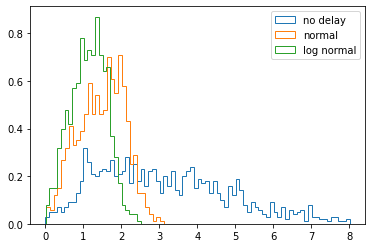

In [34]:
#plotting the three kinds of delay models (not including power law delay)
plt.hist(sample_reg, histtype='step', label = 'no delay', density=True, bins=bins_reg)
plt.hist(sample_n, histtype='step', label='normal', density=True, bins=bins_n)
plt.hist(sample_log, histtype='step', label='log normal', density=True, bins=bins_log)
plt.title('')
plt.legend()
plt.show()

## convert dN/dtdV to dN/dtdz
first, testing kernel density estimates

In [35]:
from scipy import stats

kde_reg = stats.gaussian_kde(sample_reg)
kde_n   = stats.gaussian_kde(sample_n)
kde_log = stats.gaussian_kde(sample_log)

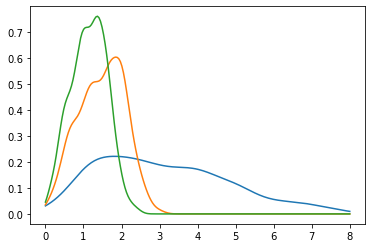

In [36]:
zs = np.linspace(0,8,200)
plt.plot(zs, kde_reg(zs))
plt.plot(zs, kde_n(zs))
plt.plot(zs, kde_log(zs))
plt.show()

In [37]:
def dVdz(z):
    '''
    WARNING: input order is NOT same as output order
    '''
    return 4*np.pi*(D_L(z)**2)/(E(z)*((1+z)**2))

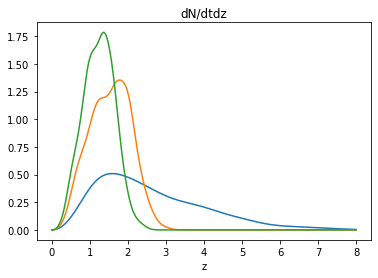

In [38]:
zs = np.linspace(0,8,200)
plt.plot(zs, kde_reg(zs)*dVdz(zs)/(1+zs))
plt.plot(zs, kde_n(zs)*dVdz(zs)/(1+zs))
plt.plot(zs, kde_log(zs)*dVdz(zs)/(1+zs))
plt.title('dN/dtdz')
plt.xlabel('z')
plt.show()

### simulating energy distribution

In [39]:
#I need to sample the dN/dtdz distribution rather than the previous dN/dtdV distribution

funcs = [kde_reg, kde_n, kde_log, None]
max_vals = [0.54, 1.42, 1.86, None]
z_cutoff = [8, 4, 3, None]

def samp_dNdtdz(samp_size, delay=None, seed=0):
    '''
    ----------I/O-----------
    INPUT: 
    samp_size — number of FRBs represented in the sample
    delay     — type of delay, default None (using SFR), can also be "gauss", "lognormal", or "power"*
    seed      – random seed, for reproducibility
    
    OUTPUT: 
    numpy array of zs, corresponding to the FRB sample
    ------------------------
    
    Notes:
    *power law not implemented yet
    seed=None makes it random seed
    
    If more than 2/3 ends up getting cut in rejection method, may have less than requested sample size. Very unlikely.
    '''
    
    choices = {None:0, 'sfr':0, 'gauss':1, 'lognormal':2, 'power':3}
    delay_str = delay
    if type(delay_str) == str:
        delay_str = delay.lower()
    num = choices[delay_str]
    
    rng = np.random.default_rng(seed)
    
    z_samps = rng.random((3*samp_size,2))
    z_samps[:,0] *= z_cutoff[num]
    z_samps[:,0] = sorted(z_samps[:,0])
    zs = z_samps[:,0]
    z_samps[:,1] *= max_vals[num]
    rem_z = z_samps[:,0][z_samps[:,1] <= funcs[num](zs)*dVdz(zs)/(1+zs)]
    if len(rem_z) < samp_size:
        print('Sample size smaller than expected.')
        return rem_z
    rng.shuffle(rem_z)
    return rem_z[:samp_size]

In [40]:
samp_zs = samp_dNdtdz(100000, delay='lognormal')

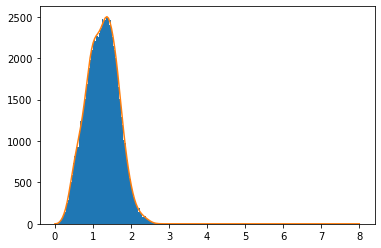

In [41]:
plt.hist(samp_zs, bins=100)
zs = np.linspace(0,8,200)
plt.plot(zs, kde_log(zs)*dVdz(zs)/(1+zs)*1400)
plt.show()

In [42]:
def dNdE(E, alpha, E_C):
    #E can be array, others must be constants
    return (E/E_C)**(-alpha) * np.exp(-E/E_C)
    
def F_v_Zhang(E, z, v_c):
    '''
    WARNING: input order is NOT same as output order
    '''
    #E and z should be arrays
    #E should be in J, v_c should be in Hz
    return (1+z)*E/(4*np.pi*(D_L(z)*c/H_0)**2*v_c*Jyms)

def samp_E(samp_size, params, tel, seed=0): #does not include Fluence cut
    alpha, E_C = params
    E_min, E_max, v_c= tel
    
    E_logspaced = np.logspace(np.log10(E_min), np.log10(E_max), 100000)
    As = np.zeros(len(E_logspaced)-1)
    for i in range(len(E_logspaced)-1):
        E_i_1, E_i = E_logspaced[i+1], E_logspaced[i]
        dNdE_av = (dNdE(E_i_1, alpha, E_C)+dNdE(E_i, alpha, E_C))/2
        dE = E_i_1 - E_i
        As[i] = dNdE_av*dE
    As /= sum(As)    
    
    rng = np.random.default_rng(seed)
    
    Es = E_logspaced[:-1] #elements
    #probabilities is As
    samp_Es = rng.choice(Es, samp_size, p=As)
    
    #add some 
    #since should be exactly part of the elements of Es, can use bleft to obtain index:
    
    dEs = E_logspaced[1:]-E_logspaced[:-1] 
    
    for i in range(len(samp_Es)):
        dE = dEs[bleft(Es, samp_Es[i])]
        samp_Es[i] += dE*rng.random()
    
    return samp_Es

## cutting by fluence, obtaining distribution of
- number of FRBs versus E
- number of FRBs versus DM

In [43]:
#may take a while
seed=7
size=100000
z_s = np.sort(samp_dNdtdz(size, delay='gauss', seed=seed)) #takes the most time
E_s = samp_E(size, [1.8, 10**41.5], [10**37.5, 1e44, 1.352e9], seed=seed)

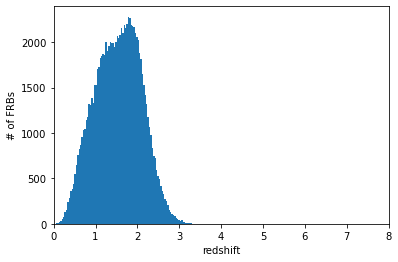

In [44]:
plt.hist(z_s,bins=100)
plt.xlabel('redshift')
plt.ylabel('# of FRBs')
plt.xlim([0,8])
plt.show()

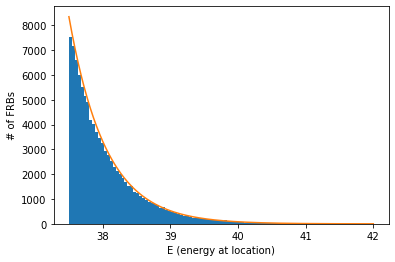

In [45]:
plt.hist(np.log10(E_s),bins=100)
plt.xlabel('E (energy at location)')
plt.ylabel('# of FRBs')
Es = np.logspace(37.5, 42, 200)
plt.plot(np.log10(Es), Es*dNdE(Es, 1.8, 10**41.5)/6e40, label='distr')
#plt.ylim([0,30])
plt.show()

### the fix:

In [46]:
#z_s needs to be sorted in this line, in order for cuts to actually work
#since D_L(z) would be wrong otherwise
Fvs = F_v_Zhang(E_s/1e7, z_s, 1.352e9) #/1e7 is erg > J

### E distribution

In [47]:
zs  = np.linspace(0,8,200)
DMs = DM(zs, dDMdz=dDMdz_Zhang)

In [48]:
#create E distribution of data
#DM_sorted, F_P_sorted
F_P_sorted = np.array(F_P_sorted)
z_P_sorted = np.zeros(len(DM_sorted))

for i, DM_i in enumerate(DM_sorted):
    z_P_sorted[i] = z_DM(DM_i, DMs, zs)

E_P_sorted = (F_P_sorted*Jyms)*4*np.pi*(D_L(z_P_sorted)*c/H_0)**2*1.352e9/(1+z_P_sorted) * 1e7 #J -> erg for the last one

NameError: name 'F_P_sorted' is not defined

NameError: name 'E_P_sorted' is not defined

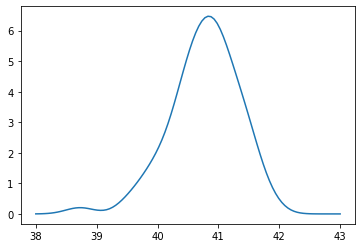

In [49]:
#energies we see:
E_seen = E_s[Fvs>2]

#plt.hist(np.log10(E_seen))
kde_E = stats.gaussian_kde(np.log10(E_seen))
plt.plot(np.linspace(38,43,100), kde_E(np.linspace(38,43,100))*9, label='gauss delay model')
plt.hist(np.log10(E_P_sorted), bins=9, label='parkes data')
plt.xlabel('E (energy at location)')
plt.ylabel('# of FRBs')
plt.xlim(38,43)
plt.legend()
#plt.savefig('gaussmodel.png', dpi=600)
plt.show()

### DM distribution

In [284]:
DM_cut = DM(z_s, dDMdz=dDMdz_Zhang)

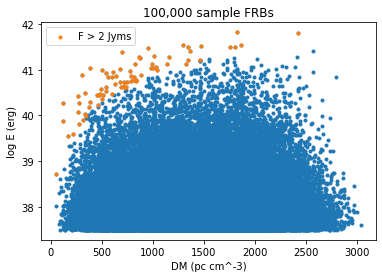

In [295]:
plt.title('100,000 sample FRBs')
plt.scatter(DM_cut, np.log10(E_s), marker='.')
plt.scatter(DM_cut[Fvs>2], np.log10(E_s)[Fvs>2], marker='.', label='F > 2 Jyms')
plt.legend()
plt.ylabel('log E (erg)')
plt.xlabel('DM (pc cm^-3)')
#plt.savefig('sampleFRBs.png', dpi=600)
plt.show()

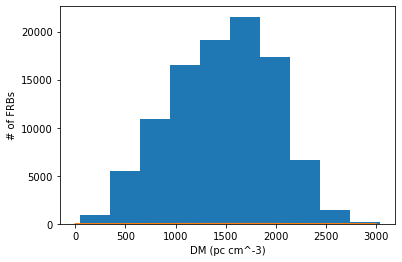

In [285]:
plt.hist(DM_cut)
kde_DM = stats.gaussian_kde(DM_cut)
plt.plot(np.linspace(0, 3000,100), kde_DM(np.linspace(0, 3000,100))*20000)
plt.ylabel('# of FRBs')
plt.xlabel('DM (pc cm^-3)')
plt.show()

# Comparison with Data

In [225]:
import pandas as pd
data = pd.read_csv("./data/frb_0602.csv")
column_meanings = data.columns
data.columns = ['name', 'utc', 'tel', 'DM_gal', 'DM', 'W', 'S/N', 'Flux', 'f_c', 'F_obs', 'DM_excess', 'bandwidth', 'repeat']
data.head()

,name,utc,tel,DM_gal,DM,W,S/N,Flux,f_c,F_obs,DM_excess,bandwidth,repeat
0,FRB190711,2019/07/11 1:53:41,ASKAP,56.40,593.10,6.5,23.8,NaN,1320.0,34.0,536.70,1.0,x
1,FRB190611,2019/06/11 5:45:43,ASKAP,57.83,321.40,2.0,9.3,NaN,1320.0,10.0,263.57,1.0,NaN
2,FRB190608,2019/06/08 22:48:13,ASKAP,37.20,338.70,6.0,16.1,NaN,1320.0,26.0,301.50,1.0,NaN
3,FRB190102,2019/01/02 5:38:43,ASKAP,57.30,363.60,1.7,14.0,NaN,1320.0,14.0,306.30,1.0,NaN
4,FRB181112,2018/11/12 17:31:15,ASKAP,102.00,589.27,2.1,19.3,NaN,1272.5,26.0,487.27,NaN,NaN


In [226]:
#modify the capital 'Parkes' to 'parkes', for easier selection of telescopes later
data.at[88, 'tel'] = 'parkes'

In [227]:
ASKAP = data[data['tel'] == 'ASKAP']
CHIME = data[data['tel'] == 'CHIME/FRB']
parkes = data[data['tel'] == 'parkes']

In [233]:
def sort_by_first(list1, list2):
    zipped_lists = zip(list1, list2)
    sorted_pairs = sorted(zipped_lists)

    tuples = zip(*sorted_pairs)
    list1, list2 = [ list(tuple) for tuple in  tuples]
    return list1, list2

In [228]:
DM_ASKAP = np.array(ASKAP['DM_excess'])
F_A      = np.array(ASKAP['F_obs'])
DM_CHIME = np.array(CHIME['DM_excess'])
F_C      = np.array(CHIME['F_obs'])
DM_parkes= np.array(parkes['DM_excess'])
F_P      = np.array(parkes['F_obs'])

In [236]:
DM_sorted, F_P_sorted = sort_by_first(DM_parkes, F_P)

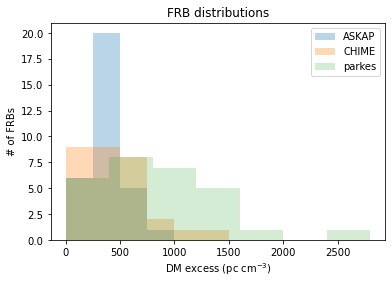

In [229]:
binwidth = 250
dmdata=DM_ASKAP
bins_A=np.arange(0, max(dmdata) + binwidth, binwidth)

binwidth = 250
dmdata=DM_CHIME
bins_C=np.arange(0, max(dmdata) + binwidth, binwidth)

binwidth = 400
dmdata=DM_parkes
bins_P=np.arange(0, max(dmdata) + binwidth, binwidth)

plt.hist(DM_ASKAP,alpha=0.3, label='ASKAP', bins=bins_A)
plt.hist(DM_CHIME,alpha=0.3, label='CHIME', bins=bins_C)
plt.hist(DM_parkes,alpha=0.2, label='parkes', bins=bins_P)
plt.title('FRB distributions')
plt.ylabel('# of FRBs')
plt.xlabel('DM excess (pc cm$^{-3}$)')
plt.legend()
plt.show()

In [174]:
data

,name,utc,tel,DM_gal,DM,W,S/N,Flux,f_c,F_obs,DM_excess,bandwidth,repeat
0,FRB190711,2019/07/11 1:53:41,ASKAP,56.40,593.10,6.5,23.8,NaN,1320.0,34.00,536.70,1.0,x
1,FRB190611,2019/06/11 5:45:43,ASKAP,57.83,321.40,2.0,9.3,NaN,1320.0,10.00,263.57,1.0,NaN
2,FRB190608,2019/06/08 22:48:13,ASKAP,37.20,338.70,6.0,16.1,NaN,1320.0,26.00,301.50,1.0,NaN
3,FRB190102,2019/01/02 5:38:43,ASKAP,57.30,363.60,1.7,14.0,NaN,1320.0,14.00,306.30,1.0,NaN
4,FRB181112,2018/11/12 17:31:15,ASKAP,102.00,589.27,2.1,19.3,NaN,1272.5,26.00,487.27,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,FRB010724,2001/07/24 19:50:02,parkes,44.58,375.00,5.0,23.0,30.00,1374.0,8.64,330.42,3.0,X
86,FRB010621,2001/06/21 13:02:11,parkes,523.00,745.00,7.0,16.3,0.41,1374.0,4.24,225.00,3.0,X
87,FRB010312,2001/03/12 11:06:48,parkes,51.00,1187.00,24.3,11.0,0.25,1374.0,5.60,1136.00,3.0,X
88,FRB010305,2001/03/05 12:29:16,parkes,36.00,350.00,9.0,10.2,4.20,1374.0,3.78,314.00,3.0,NaN


## experimental section

In [175]:
zs  = np.linspace(0,8,200)
DMs = DM(zs, dDMdz=dDMdz_Zhang)

z_A = np.zeros(len(DM_ASKAP))
z_C = np.zeros(len(DM_CHIME))
z_P = np.zeros(len(DM_parkes))

for i, DM_i in enumerate(DM_ASKAP):
    z_A[i] = z_DM(DM_i, DMs, zs)

for i, DM_i, in enumerate(DM_CHIME):
    z_C[i] = z_DM(DM_i, DMs, zs)

for i, DM_i in enumerate(DM_parkes):
    z_P[i] = z_DM(DM_i, DMs, zs)

E_A = 4*np.pi*(D_L(z_A)*c/H_0)**2*(1.352e9)*(F_A*Jyms)/(1+(z_A))**2
E_C = 4*np.pi*(D_L(z_C)*c/H_0)**2*(1.352e9)*(F_C*Jyms)/(1+(z_C))**2
E_P = 4*np.pi*(D_L(z_P)*c/H_0)**2*(1.352e9)*(F_P*Jyms)/(1+(z_P))**2

E_lim = 4*np.pi*(D_L(zs)*c/H_0)**2*(1.352e9)*(2*Jyms)/(1+(zs))**2 #2 Jyms

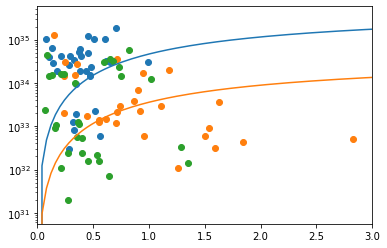

In [176]:
plt.scatter(z_A, E_A)
#plt.scatter(z_A[F_A < 26], E_A[F_A < 26])
plt.scatter(z_P, E_P)
plt.scatter(z_C, E_C)
plt.plot(zs, E_lim*26/2)
plt.plot(zs, E_lim)
plt.xlim([0,3])
plt.yscale('log')
#plt.ylim([0,10])

In [177]:
print(sum(ASKAP['F_obs'] >= 26))
print(len(ASKAP))

29
32


In [178]:

print(sum(F_P>2))
print(len(F_P))

16
28
